In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(15, 4.5)

from util import util
import numpy as np
from sklearn.mixture import GaussianMixture
import os
import pandas as pd
from sklearn.model_selection import GridSearchCV

# Load data
data_file = os.path.join('..', 'data', 'hpc.csv')
hpc = pd.read_csv(data_file, parse_dates=['timestamp'])

# Identify input columns
inputs = hpc.columns[1:-1]
ninputs = len(inputs)

# GMMs for Anomaly Detection

## Back to our HPC Problem

**Let's go back to our anomaly detection problem**

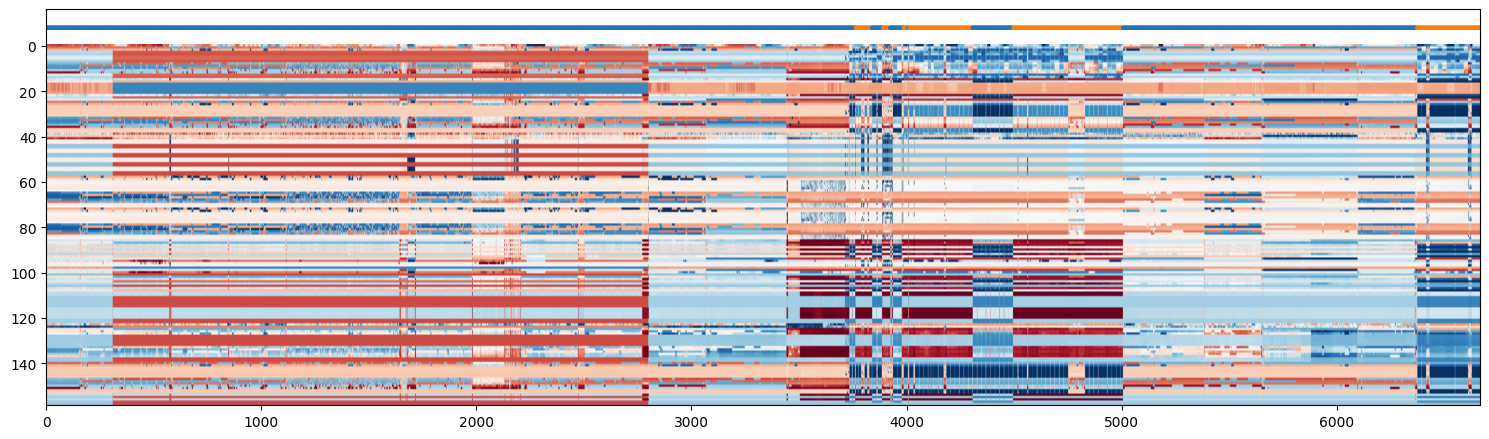

In [2]:
hpcsv = hpc.copy()
hpcsv[inputs] = (hpcsv[inputs] - hpcsv[inputs].mean()) / hpcsv[inputs].std()
labels = pd.Series(index=hpcsv.index, data=(hpcsv['anomaly'] != 0), dtype=int)
util.plot_dataframe(hpcsv[inputs], labels, figsize=figsize)

The colored line on the top identifies anomalies (in orange)

## Preprocessing

**We proceed to standardize the data again**

* This is not strictly needed for GMMs
* ...but many optimization algorithms are designed for standardized data

In [3]:
tr_end, val_end = 3000, 4500

hpcs = hpc.copy()
tmp = hpcs.iloc[:tr_end]
hpcs[inputs] = (hpcs[inputs] - tmp[inputs].mean()) / tmp[inputs].std()

We separate the training, validation, and test set

In [4]:
trdata = hpcs.iloc[:tr_end]
valdata = hpcs.iloc[tr_end:val_end]
tsdata = hpcs.iloc[val_end:]

* This time, we keep the validation set distinct from the training set

## Training and Number of Components

**We now need to pick a number of components**

We'll do this by using grid search and cross validation

* We would have used other method (e.g. elbow method or BIC)
* There are also [variants of GMMs](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html#sklearn.mixture.BayesianGaussianMixture) that can infer the number of components

In [5]:
%%time
opt = GridSearchCV(GaussianMixture(), {'n_components': [2, 4, 8]}, cv=5)
opt.fit(trdata[inputs])
print(f'Best parameters: {opt.best_params_}')

Best parameters: {'n_components': 2}
CPU times: user 6.95 s, sys: 13.7 s, total: 20.7 s
Wall time: 1.48 s


* While training is slow
* ...Generating the alarm signal is now much faster

In [6]:
ldens = opt.score_samples(hpcs[inputs])
signal = pd.Series(index=hpcs.index, data=-ldens)

## Inspecting the Alarm Signal

**Let's have a look at the alarm signal**

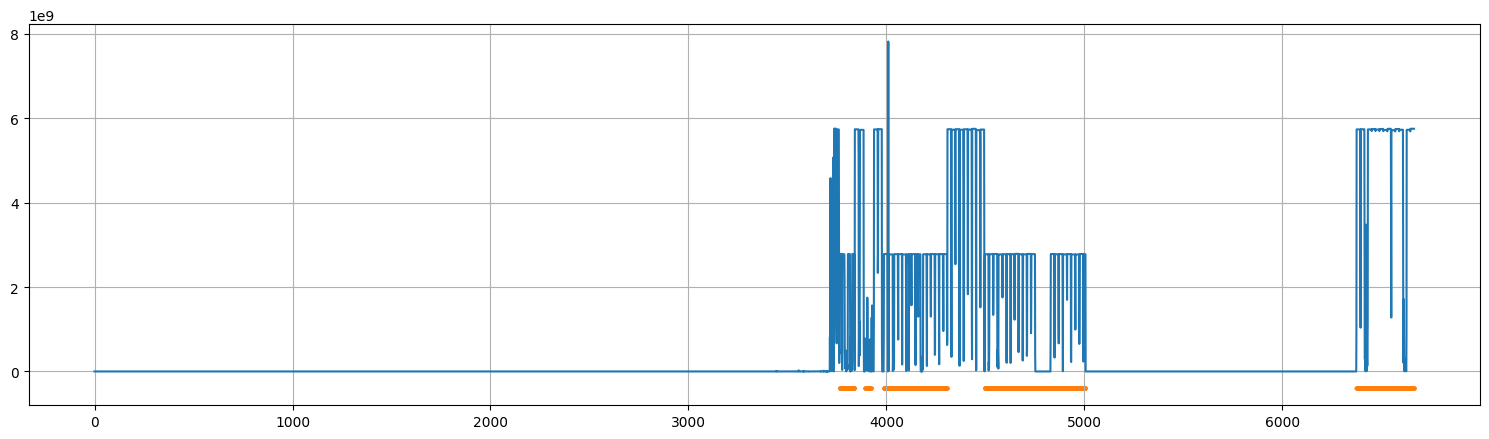

In [7]:
util.plot_signal(signal, labels, figsize=figsize)

It's very similar to the one provided by KDE

## Threshold Optimization

**We can optimize the threshold in the usual fashion**

The cost model is the same as before

In [8]:
c_alarm, c_missed, tolerance = 1, 5, 12
cmodel =  util.HPCMetrics(c_alarm, c_missed, tolerance)

th_range = np.linspace(1e4, 1e9, 1000)
th, val_cost = util.opt_threshold(signal[tr_end:val_end],
                                        valdata['anomaly'],
                                        th_range, cmodel)
print(f'Best threshold: {th:.3f}')
tr_cost = cmodel.cost(signal[:tr_end], hpcs['anomaly'][:tr_end], th)
print(f'Cost on the training set: {tr_cost}')
print(f'Cost on the validation set: {val_cost}')
ts_cost = cmodel.cost(signal[val_end:], hpcs['anomaly'][val_end:], th)
print(f'Cost on the test set: {ts_cost}')

Best threshold: 862864234.234
Cost on the training set: 0
Cost on the validation set: 242
Cost on the test set: 275


The results are also similar to those from KDE

## Behavior Clusters

**Finally, we can have a look at how the model is using its components**

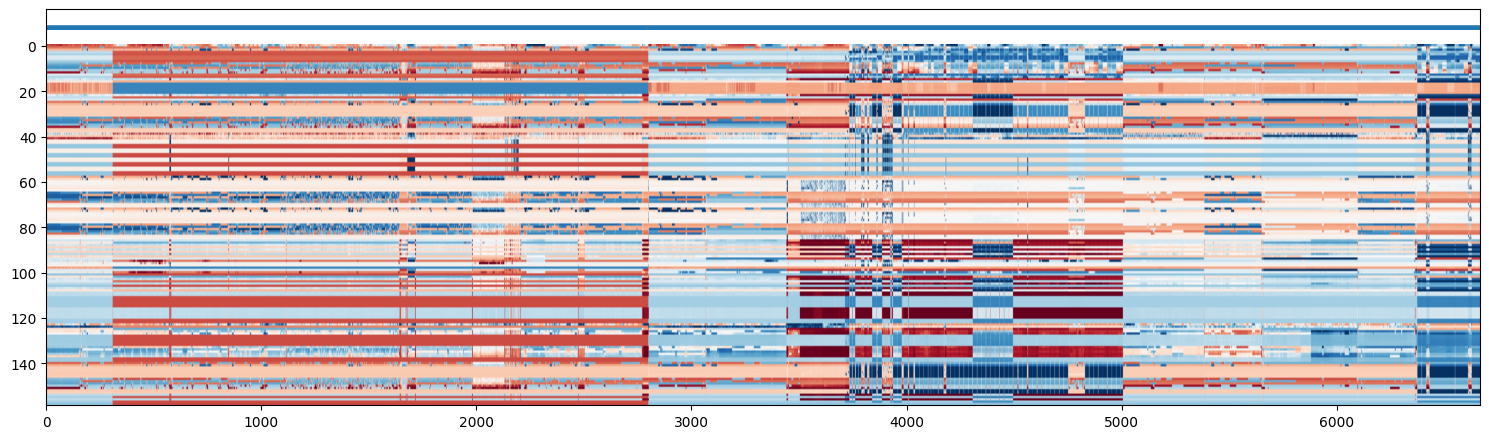

In [10]:
zvals = opt.predict(hpcs[inputs])
zsignal = pd.Series(index=hpcs.index, data=zvals)
util.plot_dataframe(hpcsv[inputs], zsignal, figsize=figsize)

* The results may vary, since some steps of the process are stochastic
* ...But typically one or more component will be use for a single, long job